<center>
    <img src="./images/ac_header.png">
</center>

### <a target="_blank" rel="noopener noreferrer" href="https://www.tu-ilmenau.de/mt-ams/personen/schuller-gerald/">Prof. Dr. -Ing. Gerald Schuller</a> <br> <a target="_blank" rel="noopener noreferrer" href="https://www.tu-ilmenau.de/mt-ams/lehre/msp-and-adsp-tutorials/">Jupyter Notebook: Renato Profeta</a> 

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# Psychoacoustics Models

## Python Example, Spreading Function

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/IAWtxHl_0gw?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

 - This Python example shows the non-linear superposition with parameter **2*a=alpha=0.6, in the Bark scale.** We construct a matrix which does the actual superposition in the Bark domain, because that is most efficient:
 
 ```python
def spreadingfunctionmat(maxfreq,nfilts,alpha):
    #Arguments: maxfreq: half the sampling frequency
    #nfilts: Number of subbands in the Bark domain, for instance 64
    fadB= 14.5+12 # Simultaneous masking for tones at Bark band 12
    fbdb=7.5 # Upper slope of spreading function
    fbbdb=26.0 # Lower slope of spreading function
    maxbark=hz2bark(maxfreq)
    spreadingfunctionBarkdB=np.zeros(2*nfilts)
    #upper slope, fbdB attenuation per Bark, over maxbark Bark (full frequency range),
    #with fadB dB simultaneous masking:
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*fbdb,-2.5,nfilts)-fadB
    #lower slope fbbdb attenuation per Bark, over maxbark Bark (full frequency range):
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*fbbdb,nfilts)-fadB
    #Convert from dB to "voltage" and include alpha exponent
    spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix=np.zeros((nfilts,nfilts))
    for k in range(nfilts):
        spreadingfuncmatrix[:,k]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
    return spreadingfuncmatrix
```

 - The application ot the spreading function is then a simple matrix multiplication (which avoids slow "for" loops) in the Bark domain, as in the following Python function:
 
 ```python
def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha):
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum,
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6)
    #return: masking threshold as "voltage" on Bark scale
    
    #mXbark: is the magnitude-spectrum mapped to the Bark scale,
    #mTbark: is the resulting Masking Threshold in the Bark scale, whose components are
    #sqrt(I_tk) on page 13.
    
    mTbark=np.dot(mXbark**alpha, spreadingfuncmatrix)
    #apply the inverse exponent to the result:
    
    mTbark=mTbark**(1.0/alpha)
    return mTbark
```

In [2]:
#Programs to implement a psycho-acoustic model
#Using a matrix for the spreading function (faster)
#Gerald Schuller, Nov. 2016
# Ported to Jupyter Notebooks by Renato Profeta, October 2020

In [3]:
def hz2bark(f):
    """ Usage: Bark=hz2bark(f)
    f    : (ndarray)    Array containing frequencies in Hz.
    Returns  :
    Brk  : (ndarray)    Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)                                                 
    return Brk

def bark2hz(Brk):
    """ Usage:
    Hz=bark2hs(Brk)
    Args     :
        Brk  : (ndarray)    Array containing Bark scaled values.
    Returns  :
        Fhz  : (ndarray)    Array containing frequencies in Hz.
    """
    Fhz = 600. * np.sinh(Brk/6.)
    return Fhz

In [4]:
def mapping2barkmat(fs, nfilts,nfft):
    #Constructing matrix W which has 1’s for each Bark subband, and 0’s else:
    #nfft=2048; nfilts=64;
    nfreqs=nfft/2
    maxbark=hz2bark(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
    nfreqs=nfft/2
    step_barks = maxbark/(nfilts-1)
    #the linspace produces an array with the fft band edges:
    binbarks = hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*fs//nfft)
    W = np.zeros((nfilts, nfft))
    for i in range(nfilts):
        W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
    return W

def mapping2bark(mX,W,nfft):
    #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    #arguments: mX: magnitude spectrum from fft
    #W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    #returns: mXbark, magnitude mapped to the Bark scale
    nfreqs=int(nfft/2)
    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
    return mXbark

def mappingfrombarkmat(W,nfft):
    #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #usuage: W_inv=mappingfrombarkmat(Wnfft)
    #argument: W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    nfreqs=int(nfft/2)
    W_inv= np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def mappingfrombark(mTbark,W_inv,nfft):
    #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #arguments:
    #mTbark: masking threshold in the Bark domain
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #nfft: : number of subbands in fft
    #returns: mT, masking threshold in the linear scale
    nfreqs=int(nfft/2)
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT

In [5]:
def f_SP_dB(maxfreq,nfilts):
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64   
    maxbark=hz2bark(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
    #Number of our Bark scale bands over this range: nfilts=64
    spreadingfunctionBarkdB=np.zeros(2*nfilts)
    #Spreading function prototype, "nfilts" bands for lower slope 
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*27,-8,nfilts)-23.5
    #"nfilts" bands for upper slope:
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*12.0,nfilts)-23.5
    return spreadingfunctionBarkdB

def spreadingfunctionmat(maxfreq,nfilts,alpha):
    #Arguments: maxfreq: half the sampling frequency
    #nfilts: Number of subbands in the Bark domain, for instance 64
    fadB= 14.5+12 # Simultaneous masking for tones at Bark band 12
    fbdb=7.5 # Upper slope of spreading function
    fbbdb=26.0 # Lower slope of spreading function
    maxbark=hz2bark(maxfreq)
    spreadingfunctionBarkdB=np.zeros(2*nfilts)
    #upper slope, fbdB attenuation per Bark, over maxbark Bark (full frequency range), with fadB dB simultaneous masking:
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*fbdb,-2.5,nfilts)-fadB
    #lower slope fbbdb attenuation per Bark, over maxbark Bark (full frequency range):
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*fbbdb,nfilts)-fadB
    #Convert from dB to "voltage" and include alpha exponent
    spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix=np.zeros((nfilts,nfilts))
    for k in range(nfilts):
        spreadingfuncmatrix[:,k]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
    return spreadingfuncmatrix


def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6), 
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64  
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
    #Compute the non-linear superposition:
    mTbark=np.dot(mXbark**alpha, spreadingfuncmatrix**alpha)
    #apply the inverse exponent to the result:
    mTbark=mTbark**(1.0/alpha)
    #Threshold in quiet:
    maxfreq=fs/2.0
    maxbark=hz2bark(maxfreq)
    step_bark = maxbark/(nfilts-1)
    barks=np.arange(0,nfilts)*step_bark
    #convert the bark subband frequencies to Hz:
    f=bark2hz(barks)+1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mTbark=np.max((mTbark, 10.0**((LTQ-60)/20)),0)
    return mTbark

 - We can take a look at the resulting spreading function matrix with:

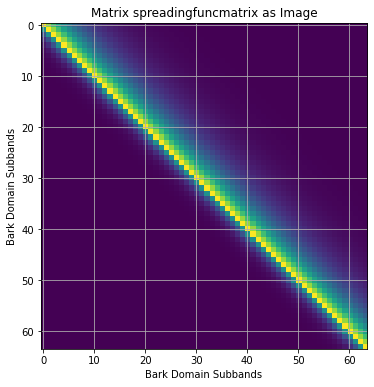

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fs=32000 # sampling frequency of audio signal
maxfreq=fs/2
alpha=0.6 #Exponent for non-linear superposition of spreading functions
nfilts=64 #number of subbands in the bark domain
spreadingfuncmatrix=spreadingfunctionmat(maxfreq,nfilts,alpha)
plt.figure(figsize=(10,6))
plt.imshow(spreadingfuncmatrix)
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.grid()

## Masking Neighboring Bands Non-Linear Superposition

 - Observe that we **don't need any tonality estimation** for this model!
 - Usually our signal from the filter bank is like a "voltage", not like a power as in this model.
 - We obtain a **"power"** if we **square** our signal.
 - Hence our exponent is multiplied by a factor of 2.
 - We get a $\rightarrow$ 2*a, hence our exponent becomes 0.6.
 
 
 - Observe: The frequency index is on the **Bark-scale**, as can be seen in slide 12.
 - Hence we need a **mapping** from **Hertz to Bark**, from our linear filter bank scale to the bark scale, where we apply masking.
 - Then we need an **inverse mapping**, from **Bark to Hertz**, to apply our found masking threshold to the **quantization stepsizes** of our **linearly spaced** subbands.

## Bark Scale Approximations

 - There are several functional approximations of the Bark scale for this mapping.
 - An example of an overview can be seen in:

In [7]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/sXgsZgr2Akc?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [8]:
%%html
<iframe src="https://ccrma.stanford.edu/courses/120-fall-2003/lecture-5.html" width="900" height="600"> </iframe>

 - The approximation we previously saw is from: <br> Zwicker & Terhardt (1980), "Analytical expressions for critical-band rate and critical bandwidth as a function of frequency", Article in The Journal of the Acoustical Society of America 68(5):1523 · November 1980
 https://www.researchgate.net/publication/209436182_Analytical_expressions_for_critical-band_rate_and_critical_bandwidth_as_a_function_of_frequency
 
 
 - In Python notation, the approximation is, with f in Herz and z in Bark:
```python 
z=13*arctan(0.00076*f)+3.5*arctan((f/7500.0)**2)
```

 - It only has an approximate closed form inverse formula, according to http://www.auditory.org/postings/1995/34.html
```python
f= (((exp(0.219*z)/352.0)+0.1)*z-0.032*exp(-0.15*(z-5)**2))*1000
```
 
 - We can test the Zwicker & Terhard approximation in ipython:

### Bark Scale Approximations, Zwicker&Terhard

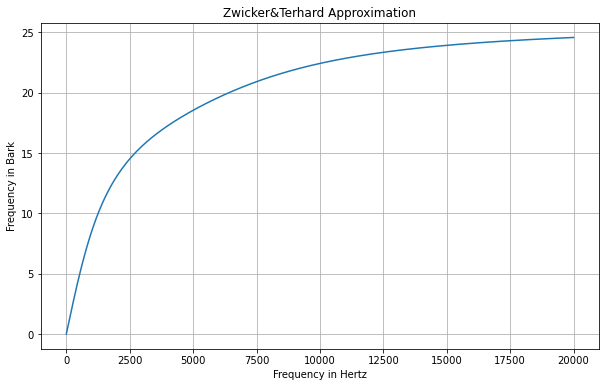

In [9]:
#Frequency array between 0 and 20000 Hz in 1000 steps:
f=np.linspace(0,20000,1000)
#Computation of Zwickers Bark approximation formula:
z=13*np.arctan(0.00076*f)+3.5*np.arctan((f/7500.0)**2)
#plot Bark over Hertz:
plt.figure(figsize=(10,6))
plt.plot(f,z)
plt.xlabel('Frequency in Hertz')
plt.ylabel('Frequency in Bark')
plt.title('Zwicker&Terhard Approximation')
plt.grid()

### Bark Scale Approximations, Zwicker&Terhard, Inverse

 - We can test the Zwicker & Terhard **inverse** approximation in ipython:

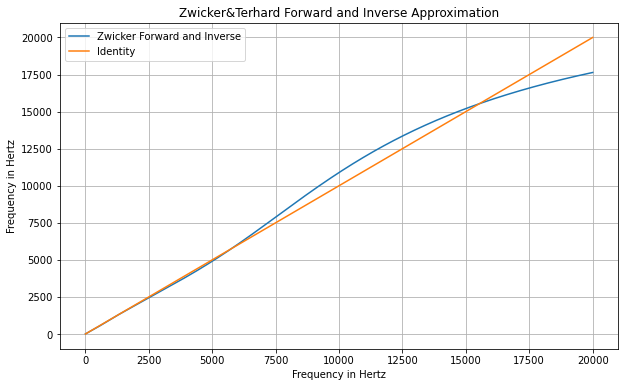

In [10]:
#Frequency array between 0 and 20000 Hz in 1000 steps:
f=np.linspace(0,20000,1000)
#Computation of Zwickers Bark approximation formula:
z=13*np.arctan(0.00076*f)+3.5*np.arctan((f/7500.0)**2)
#computation of the approximate inverse, frec: reconstructed freq.:
frec= (((np.exp(0.219*z)/352.0)+0.1)*z-0.032*np.exp(-0.15*(z-5)**2))*1000
#plot reconstructed freq. Over original freq:
plt.figure(figsize=(10,6))
plt.plot(f,frec)
#comparison: identity:
plt.plot(f,f)
plt.xlabel('Frequency in Hertz')
plt.ylabel('Frequency in Hertz')
plt.title('Zwicker&Terhard Forward and Inverse Approximation')
plt.legend(('Zwicker Forward and Inverse','Identity'))
plt.grid()

### Bark Scale Approximations, Traunmueller

 - Traunmueller-formula, 1990, from: <br> Traunmüller, H. (1990). "Analytical expressions for the tonotopic sensory scale". The Journal of the Acoustical Society of America.
 - In Python notation, **the approximation** is, with f in Herz and z in Bark:
     - for **above 200 Hz:** <br> z=26.81*f/(1960.0+f)-0.53
     - **below 200 Hz:** <br> z= f/102.9
 - It has an **exact inverse:**
     - **Above 200 Hz:** <br> f=1960.0/(26.81/(z+0.53)-1)
     - **Below 200 Hz:** <br> f=z*102.9

### Bark Scale Approximations, Schröder

- Schroeder, M. R. (1977). Recognition of complex acoustic signals, Signal & Life Sciences Research Report 5, edited by T. H. Bullock (Abakon Verlag, Berlin), p. 324.
- See also: "Perceptual linear predictive (PLP) analysis of speech" by Hynek Hermansky, J. AcousL Soc. Am. 87 (4). April 1990,
- Also used in the PEAQ standard for objective quality estimation (eq. (2) in the paper:

In [11]:
%%html
<iframe src="https://www.ee.columbia.edu/~dpwe/papers/Thiede00-PEAQ.pdf" width="900" height="600"></iframe>

 - **It is the simplest Approximation:** <br> z= 6*arcsinh(f/600.0)
 - It has an **exact inverse**, Bark to Hertz: <br> f=600 * sinh(z/6.0)

### Bark Scale Approximations, Comparisons

 - Comparison of our functional approximation with our Bark-Table.
 - The approximation formulas also give fractional Bark numbers, and the integer Bark numbers correspond to unique frequencies, which are a band limit.
 - Tables name bands after an integer Bark number, but they differ in if the band above or below is named after that number.
 - In the lecture table this integer Bark number corresponds to the lower limit of the band, hence it starts with index 0, in other literature (CCRMA Webpage) and Wikipedia to the upper limit, starting with index 1!
 - We use these pairs out of the table for our comparison:
     - 1 bark - 100Hz
     - 10 Bark - 1270Hz
     - 15 - 2700 Hz
     - 20 - 6400 Hz
     - 22 - 9500 Hz 

   - Use ipython for the comparison:

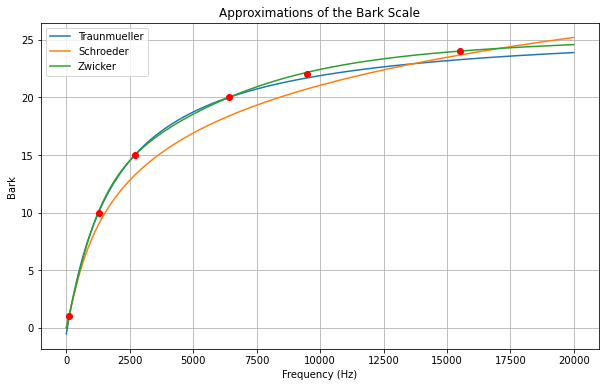

In [12]:
f=np.arange(0,20000,10)
z=26.81*f/(1960.0+f)-0.53 #Traunmueller
plt.figure(figsize=(10,6))
plt.plot(f,z)
z= 6*np.arcsinh(f/600.0) #Schroeder
plt.plot(f,z)
z=13*np.arctan(0.00076*f)+3.5*np.arctan((f/7500.0)**2) #Zwicker
plt.plot(f,z)
plt.legend(('Traunmueller','Schroeder','Zwicker'))
#plot single comparison points:
plt.plot([100,1270,2700,6400,9500,15500],[1,10,15,20,22,24],'ro')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Bark')
plt.title('Approximations of the Bark Scale')
plt.grid()

 - **Observe:** The Zwicker approximation is the most precise, it hits our test points, but it has no closed form inverse.
 - The Schroeder approximation is the least accurate, but it is the simplest and it has an exact inverse in closed form, hence it is used most often, and we will also use it.
 - In Python we use the function:
```python
def hz2bark(f):
    """ Method to compute Bark from Hz. Based on :
    https://github.com/stephencwelch/Perceptual-Coding-In-Python
    Args :
    f : (ndarray) Array containing frequencies in Hz.
    Returns :
    Brk : (ndarray) Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)
    return Brk
```

- The inverse function in Python is:
```python
def bark2hz(Brk):
    """ Method to compute Hz from Bark scale. Based on :
    https://github.com/stephencwelch/Perceptual-Coding-In-Python
    Args :
    Brk : (ndarray) Array containing Bark scaled values.
    Returns :
    Fhz : (ndarray) Array containing frequencies in Hz.
    """
    Fhz = 600. * np.sinh(Brk/6.)
    return Fhz
```


### Bark Scale Mapping

In [56]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/anqH-0vPDtg?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

 - We choose 64 subbands in the Bark scale, hence each about 1/3 Bark wide.
 - In Python we construct a matrix W for this mapping (again, to avoid slow "for" loops), which has 1's at the position of each such 1/3 Bark band:
 
 ```python
def mapping2barkmat(fs, nfilts,nfft):
    #Constructing matrix W which has 1’s for each Bark subband, and 0’s else:
    #nfft=2048; nfilts=64;
    nfreqs=nfft/2
    #the linspace produces an array with the fft band edges:
    binbarks = hz2bark(np.linspace(0,(nfft/2),(nfft/2)+1)*fs/nfft)
    W = np.zeros((nfilts, nfft))
    for i in xrange(nfilts):
        W[i,0:(nfft/2)+1] = (np.round(binbarks/step_barks)== i)
    return W
```

 - Matrix W as image in Python:

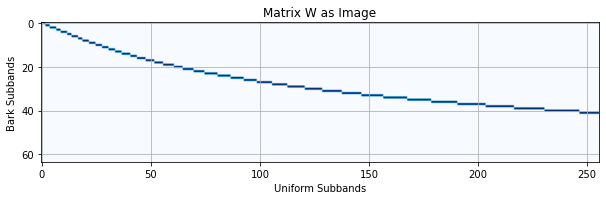

In [13]:
fs=32000
W=mapping2barkmat(fs,64,2048)
plt.figure(figsize=(10,6))
plt.imshow(W[:,:256],cmap='Blues')
plt.title('Matrix W as Image')
plt.xlabel('Uniform Subbands')
plt.ylabel('Bark Subbands')
plt.grid()

 - For each such 1/3 bark subband we add the signal powers from the corresponding DFT bands.
 - Then we take the square root to obtain a "voltage" again.
 - As Python function:
 ```python
def mapping2bark(mX,W,nfft):
    #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    #returns: mXbark, magnitude mapped to the Bark scale
    #Frequency of each FFT bin in Bark, in 1025 frequency bands (from call)
    #nfft=2048; nfilts=64;
    nfreqs=nfft//2
    #Frequencies of each FFT band, up to Nyquits frequency, converted to Bark:
    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
    return mXbark
```

### Mapping from Bark scale back to Linear

 - After having computed the masking threshold in the Bark scale, we need to map it back to the linear scale of our filter bank.
 - For that we need to "distribute" the corresponding power of each of our 1/3 Bark bands into the corresponding filter bank bands on the linear frequency scale.
 - Then we take the square root to obtain a "voltage" again.
 - We again contruct a matrix to do that in Python. When there is 1 subband in the 1/3 bark scale, it gets a factor 1, if there are 2 subbands, they get a factor of sqrt(2), and so on, using a diagonal matrix multiplication for those factors. It is an 64x1024 matrix:
```python
def mappingfrombarkmat(W,nfft):
    #Constructing matrix W_inv from matrix W for mapping back from bark
    #scale
    #nfft=2048;
    nfreqs=nfft//2
    W_inv= np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv
```

 - Matrix W_inv as image in python:

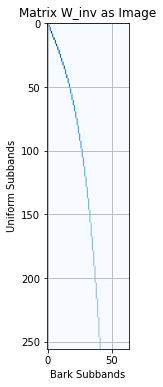

In [14]:
W_inv=mappingfrombarkmat(W, nfft=2018)
plt.figure(figsize=(10,6))
plt.imshow(W_inv[:256,:],cmap='Blues')
plt.title('Matrix W_inv as Image')
plt.xlabel('Bark Subbands')
plt.ylabel('Uniform Subbands')
plt.grid()

 - The function for mapping the masking threshold from Bark scale to linear scale is:
 ```python
def mappingfrombark(mTbark,W_inv, nfft=2048):
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #returns: mT, masking threshold in the linear scale
    nfreqs=nfft/2
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT
```

## Hearing Threshold in Quiet

In [100]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/kjMg_VJDREI?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

 - On top of our signal adaptive masking threshold, we have the threshold in quiet.
 - We have an approximation formula from Zoelzer: "Digital Audio Signal Processing".
 - For the case of quiet and only a barely audible test tone.
 - The approximation for this Level of the Threshold in Quiet, LTQ, in dB and in Python notation is:<br>
 
 LTQ=3.64 * (f/1000.) **(-0.8) - 6.5*np.exp( -0.6 * (f/1000. - 3.3) ** 2.) + 1e-3*((f/1000.) ** 4.)
 
 - Plot it with python:

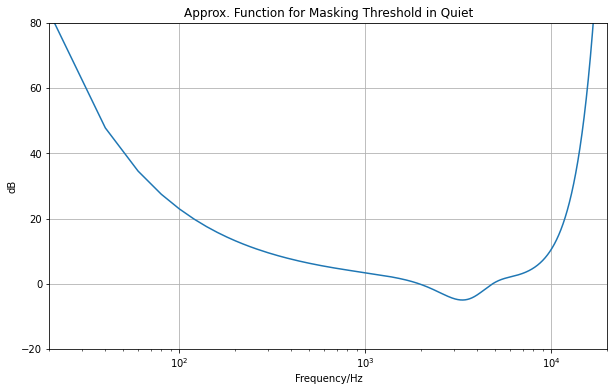

In [15]:
f=np.linspace(20,20000,1000)
LTQ=3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)
plt.figure(figsize=(10,6))
plt.semilogx(f,LTQ)
plt.axis([20,20000, -20,80])
plt.xlabel('Frequency/Hz')
plt.ylabel('dB')
plt.title('Approx. Function for Masking Threshold in Quiet')
plt.grid()

 - The dB of the formula is for sound pressure. Our internal representation has +-1 as a full scale, which corresponds to 0 dB. Assume we play back our audio signal such that full scale appears at a sound level of speech, which is about 60 dB. Hence to convert the sound level to our internal representation, we need to reduce the threshold of quiet by **60 dB.**
 
 - Even with an audio signal the masking threshold in quiet still matters at the lowest and highest frequencies.
 - We **combine** the signal dependent masking threshold and the threshold in quiet by taking the **maximum** of the two at each frequency.
 - In Python we clip the result to avoid overloading and numerical problems, and correct our masking threshold with:
 ```python
LTQ=np.clip(LTQ,-20,60)
#Shift dB according to our internal representation:
LTQ=LTQ-60```

 - We can test our approximation formula for our hearing threshold in quiet by producing noise below this spectral threshold, and then listen to it. If we don’t hear the noise it works! 
 
 We can use the Python function noisefromdBSpectrum(spec,fs):

In [53]:
from numpy.fft import fft, ifft
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency
    plt.figure(figsize=(10,6))
    plt.plot(spec)
    plt.xlabel('DFT subband (lower half)')
    plt.ylabel('dB')
    plt.title('Noise Magnitude Spectrum')
    plt.grid()
  
    specvoltage=10.0**(spec/20.0)

    #produce 40 blocks of sound:
    noise=[]
    for m in range(40):
        #Noise in the range of -1...+1, and Multiply noise with spectrum:
        noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2

        #make spectrum symmetric for ifft: 
        #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
        noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
        noise_ifft=np.real(ifft(noisespec,norm='ortho'))
        noise=np.append(noise,noise_ifft)
        
    plt.figure(figsize=(10,6))
    plt.plot(noise)
    plt.title('Produced Noise Signal in the Time Domain')
    plt.grid()
    return (noise, fs)

Then we can listen to the sound corresponing to our threshold approximation with with:

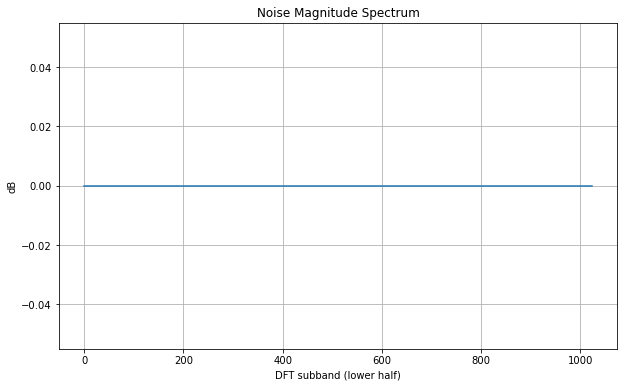

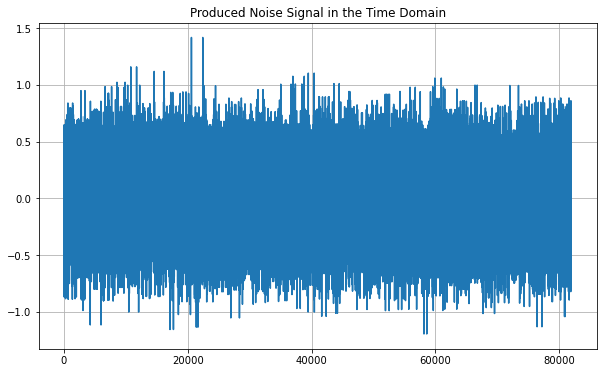

In [54]:
fs=32000 # sampling frequency
N=1024 #number of subbands
#spectrum in dB sound level, 60 dB: speaking level:
spec=np.ones(1024)*60.0
#Convert to range of internal representation: Value 1 or 0 dB is full level,
#assume full level will result in 60 dB sound level from sound volume level:
spec=spec-60.0

noise, fs = noisefromdBSpectrum(spec,fs)

noise/=np.abs(noise).max()
import IPython.display as ipd
display(ipd.Audio(noise,rate=fs))

D:\Anaconda3\envs\TU_Ilmenau\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


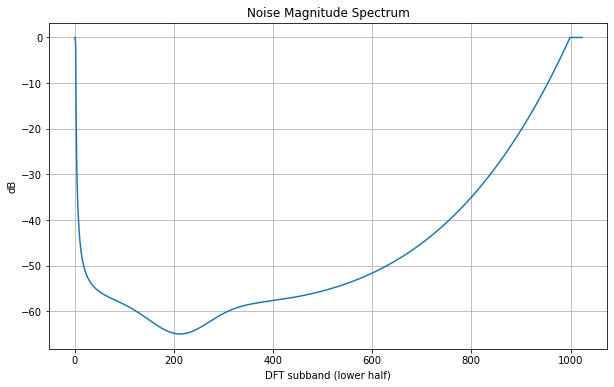

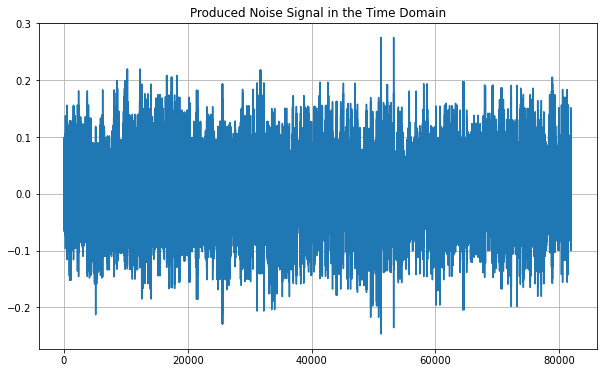

In [55]:
fs=32000    # sampling frequency
N=1024      # number of subbands
f=np.linspace(0,fs/2,N)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
#LTQ=(3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.))
#LTQ/=np.abs(LTQ).max()
#Shift dB according to our internal representation:
LTQ=LTQ-60
#Play back noise shaped like the masking theshold in quoet:
#Normalize
noise, fs = noisefromdBSpectrum(LTQ,fs)

noise/=np.abs(noise).max()
import IPython.display as ipd
display(ipd.Audio(noise,rate=fs))

**Observe:** White noise (flat spectrum) is clearly audible
Noise shaped according to our threshold approximation should be inaudible! Apart from the clicks that are artifacts by the blocks generating the audio.

## The Complete Psycho-Acoustic Model

 - Now our complete psycho-acoustic model for the computation of our masking threshold is:
 

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Fd4dWeog1iU?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [58]:
def maskingThreshold(mX, W, W_inv,fs,spreadingfuncmatrix,alpha,nfft):
    #Input: magnitude spectrum of a DFT of size 2048
    #Returns: masking threshold (as voltage) for its first 1025 subbands
    #Map magnitude spectrum to 1/3 Bark bands:
    mXbark=mapping2bark(mX,W, nfft)
    #Compute the masking threshold in the Bark domain:
    mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Map back from the Bark domain,
    #Result is the masking threshold in the linear domain:
    mT=mappingfrombark(mTbark,W_inv,nfft)
    #Threshold in quiet:
    f=np.linspace(0,fs/2,1025)
    LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,80)
    mT=np.max((mT, 10.0**((LTQ-60)/20)),0)
    return

This example is an idealized tone in one subband, and its resulting masking threshold, which is mostly its spreading function:

 <center>
    <br>
    <img src='./images/ac_05_01_ltq.png' width='600'>
</center>  

In [59]:
#Programs to implement a psycho-acoustic model
#Using a matrix for the spreading function (faster)
#Gerald Schuller, Nov. 2016

# Ported to Jupyter Notebook by Renato Profeta, October 2020

In [60]:
import numpy as np

In [61]:
def f_SP_dB(maxfreq,nfilts):
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64   
    
    maxbark=hz2bark(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
    
    #Number of our Bark scale bands over this range: nfilts=64
    spreadingfunctionBarkdB=np.zeros(2*nfilts)
   
    #Spreading function prototype, "nfilts" bands for lower slope 
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*27,-8,nfilts)-23.5
   
    #"nfilts" bands for upper slope:
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*12.0,nfilts)-23.5
    return spreadingfunctionBarkdB

In [62]:
def spreadingfunctionmat(spreadingfunctionBarkdB,alpha,nfilts):
    #Turns the spreading prototype function into a matrix of shifted versions.
    #Convert from dB to "voltage" and include alpha exponent
    #nfilts: Number of subbands in the Bark domain, for instance 64  
    spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
    
    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix=np.zeros((nfilts,nfilts))
    
    for k in range(nfilts):
        spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
    
    return spreadingfuncmatrix

In [63]:
def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6), 
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64  
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
    #Compute the non-linear superposition:
    mTbark=np.dot(mXbark**alpha, spreadingfuncmatrix**alpha)
  
    #apply the inverse exponent to the result:
    mTbark=mTbark**(1.0/alpha)
  
    #Threshold in quiet:
    maxfreq=fs/2.0
    maxbark=hz2bark(maxfreq)
    step_bark = maxbark/(nfilts-1)
    barks=np.arange(0,nfilts)*step_bark
  
    #convert the bark subband frequencies to Hz:
    f=bark2hz(barks)+1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mTbark=np.max((mTbark, 10.0**((LTQ-60)/20)),0)
    return mTbark

In [64]:
def hz2bark(f):
    """ Usage: Bark=hz2bark(f)
    f    : (ndarray)    Array containing frequencies in Hz.
    Returns  :
    Brk  : (ndarray)    Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)                                                 
    return Brk

In [65]:
def bark2hz(Brk):
    """ Usage:
    Hz=bark2hs(Brk)
    Args     :
        Brk  : (ndarray)    Array containing Bark scaled values.
    Returns  :
        Fhz  : (ndarray)    Array containing frequencies in Hz.
    """
        
    Fhz = 600. * np.sinh(Brk/6.)
    return Fhz

In [82]:
def mapping2barkmat(fs, nfilts,nfft):
    #Constructing matrix W which has 1’s for each Bark subband, and 0’s else:
    #nfft=2048; nfilts=64;
    nfreqs=nfft/2
    maxbark=hz2bark(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
    nfreqs=nfft/2
    step_barks = maxbark/(nfilts-1)
    #the linspace produces an array with the fft band edges:
    binbarks = hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*fs//nfft)
    W = np.zeros((nfilts, nfft))
    for i in range(nfilts):
        W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
    return W

In [83]:
def mapping2bark(mX,W,nfft):
    #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    #arguments: mX: magnitude spectrum from fft
    #W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    #returns: mXbark, magnitude mapped to the Bark scale
    
    nfreqs=int(nfft/2)
    
    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
    
    return mXbark

In [84]:
def mappingfrombarkmat(W,nfft):
    #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #usuage: W_inv=mappingfrombarkmat(Wnfft)
    #argument: W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    nfreqs=int(nfft/2)
    W_inv= np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

In [85]:
def mappingfrombark(mTbark,W_inv,nfft):
    #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #arguments:
    #mTbark: masking threshold in the Bark domain
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #nfft: : number of subbands in fft
    #returns: mT, masking threshold in the linear scale
  
    nfreqs=int(nfft/2)
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT

**Testing**

In [86]:
import matplotlib.pyplot as plt

In [87]:
fs=32000  # sampling frequency of audio signal
maxfreq=fs/2
alpha=0.8  #Exponent for non-linear superposition of spreading functions
nfilts=64  #number of subbands in the bark domain
nfft=2048  #number of fft subbands

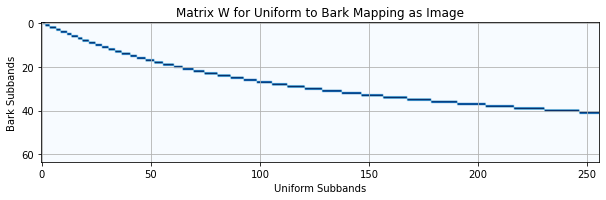

In [88]:
W=mapping2barkmat(fs,nfilts,nfft)
plt.figure(figsize=(10,6))
plt.imshow(W[:,:256],cmap='Blues')
plt.title('Matrix W for Uniform to Bark Mapping as Image')
plt.xlabel('Uniform Subbands')
plt.ylabel('Bark Subbands')
plt.grid()

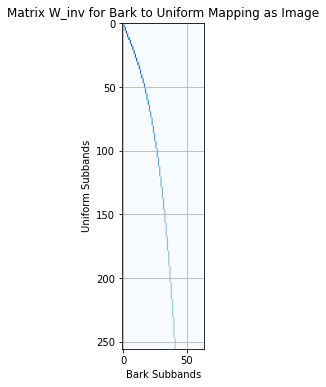

In [89]:
W_inv=mappingfrombarkmat(W,nfft)
plt.figure(figsize=(10,6))
plt.imshow(W_inv[:256,:],cmap='Blues')
plt.title('Matrix W_inv for Bark to Uniform Mapping as Image')
plt.xlabel('Bark Subbands')
plt.ylabel('Uniform Subbands')
plt.grid()

maxfreq= 16000.0 maxbark= 23.86147742289682


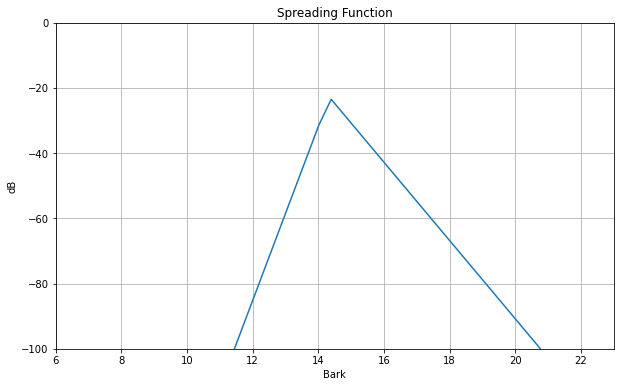

In [91]:
spreadingfunctionBarkdB=f_SP_dB(maxfreq,nfilts)

#x-axis: maxbark Bark in nfilts steps:

maxbark=hz2bark(maxfreq)
print("maxfreq=", maxfreq, "maxbark=", maxbark)

bark=np.linspace(0,maxbark,nfilts)

#The prototype over "nfilt" bands or 22 Bark, its center 
#shifted down to 22-26/nfilts*22=13 Bark:
plt.figure(figsize=(10,6))
plt.plot(bark,spreadingfunctionBarkdB[26:(26+nfilts)])
plt.axis([6,23,-100,0])
plt.xlabel('Bark')
plt.ylabel('dB')
plt.title('Spreading Function')
plt.grid()

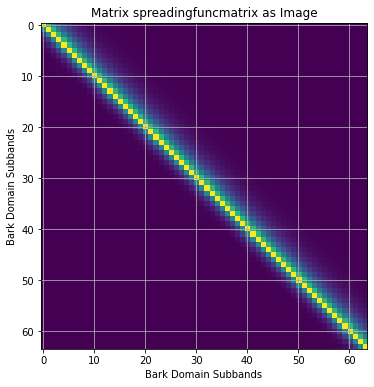

In [92]:
spreadingfuncmatrix=spreadingfunctionmat(spreadingfunctionBarkdB,alpha, nfilts)
plt.figure(figsize=(10,6))
plt.imshow(spreadingfuncmatrix)
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.grid()

#### A test magnitude spectrum: White Noise

In [95]:
#A test magnitude spectrum:
# White noise:
x=np.random.randn(32000)*1000
ipd.Audio(x,rate=32000)

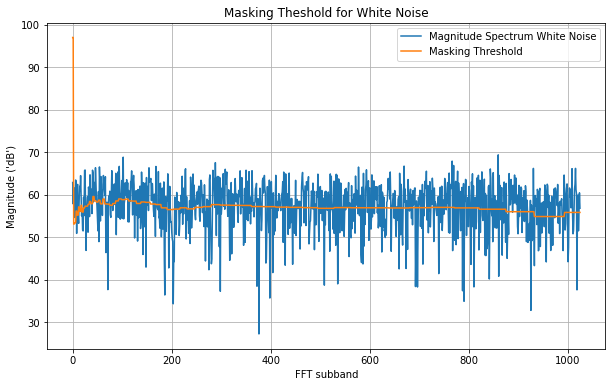

In [96]:
mX=np.abs(np.fft.fft(x[0:2048],norm='ortho'))[0:1025]
mXbark=mapping2bark(mX,W,nfft)

#Compute the masking threshold in the Bark domain:  
mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)

#Massking threshold in the original frequency domain
mT=mappingfrombark(mTbark,W_inv,nfft)
plt.figure(figsize=(10,6))
plt.plot(20*np.log10(mX+1e-3))
plt.plot(20*np.log10(mT+1e-3))
plt.title('Masking Theshold for White Noise')
plt.legend(('Magnitude Spectrum White Noise','Masking Threshold'))
plt.xlabel('FFT subband')
plt.ylabel("Magnitude ('dB')")
plt.grid()

#### A test magnitude spectrum, an idealized tone in one subband: tone at FFT band 200:

In [98]:
#A test magnitude spectrum, an idealized tone in one subband:
#tone at FFT band 200:
x=np.sin(2*np.pi/nfft*200*np.arange(32000))*1000
ipd.Audio(x,rate=32000)

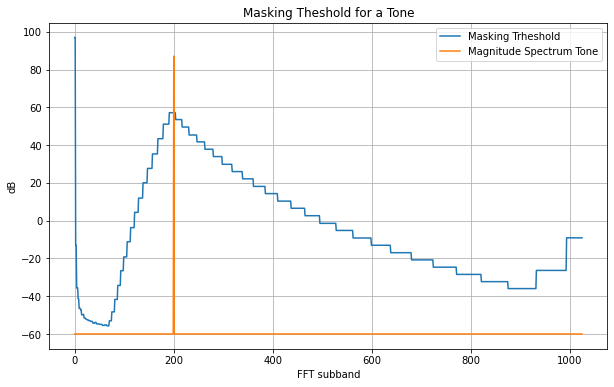

In [99]:
mX=np.abs(np.fft.fft(x[0:2048],norm='ortho'))[0:1025]

#Compute the masking threshold in the Bark domain:  
mXbark=mapping2bark(mX,W,nfft)
mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
mT=mappingfrombark(mTbark,W_inv,nfft)
plt.figure(figsize=(10,6))
plt.plot(20*np.log10(mT+1e-3))
plt.title('Masking Theshold for a Tone'),
plt.plot(20*np.log10(mX+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.grid()

## Physical Models of Hearing

 - Physical models don’t model the effects of hearing, but the **physical functioning** of the **inner ear** instead.
 - As a result, their output is an **internal representation**, not a masking threshold.
 - But they can still be used to compute a **similarity measure** of 2 different sounds, as perceived by the human ear, **by comparing their internal representations.**
 - An example is the **"PEMO-Q"** measure, to estimate the "quality" of a sound compared to an original.

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/CulE7VNtf5Q?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [107]:
%%html
<iframe src="https://ieeexplore.ieee.org/document/1709880" width="900" height="600"></iframe>

 - It is used as part of "PEASS" toolkit.
 
"Perceptual Evaluation methods for Audio Source Separation"

The PEASS toolkit provides:

 - The PEASS Software: a set of objective measures for the perceptual evaluation of audio source separation
 - The PEASS Subjective Database: a set of subjective measures resulting from listening tests about the perceptual evaluation of audio source separation
 - The PEASS Listening Test GUI: a Matlab GUI to perform MUSHRA tests in the case of the subjetive evaluation of audio source separation, according to the proposed test protocol.
 - The PEASS Examples: a set of audio examples that illustrates the proposed method (see the PEASS Software) to decompose of the distortion into specific components.
 
 http://bass-db.gforge.inria.fr/peass/

In [108]:
%%html
<iframe src="https://hal.inria.fr/inria-00567152/PDF/emiya2011.pdf" width="900" height="600"></iframe>

 - This is used for instance for measuring the quality of **audio source separation**.

### PEMO Model

 <center>
    <br>
    <img src='./images/ac_05_02_pemo.png' width='900'>
</center> 
<cite> From http://ieeexplore.ieee.org/Xplore/login.jsp?url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F10376%2F36074%2F01709880.pdf&authDecision=-203 </cite>